In [1]:
%pylab inline 
import pandas as pd 
import joblib

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load the selected variant indices
selected_variant_df = joblib.load('new_selected_variants_df.pkl')

# Use these indices to filter future VCF data
#filtered_vcf_data = vcf_data.iloc[selected_variant_indices]  # Assuming vcf_data is your future data

In [3]:
bed_df = selected_variant_df[['#CHROM', 'POS', 'REF', 'ALT']].copy()

# Adjust the POS column for BED's 0-based start (subtract 1)
bed_df['start'] = bed_df['POS'] - 1
bed_df['end'] = bed_df['POS']

# Rearrange columns for BED format (chromosome, start, end, followed by REF and ALT)
bed_df = bed_df[['#CHROM', 'start', 'end', 'REF', 'ALT']]

# Write the dataframe to a BED file
bed_df.to_csv('new_SVM_hg38.bed', sep='\t', header=False, index=False)

print("BED file has been created: selected_variant.bed")

BED file has been created: selected_variant.bed


In [13]:
bed_df.shape

(4723, 5)

In [14]:
hg19_bed.shape

(4729, 5)

In [15]:
bed_df.reset_index(drop=True, inplace=True)

In [4]:
#Import lift over 
hg19_bed = pd.read_csv('new_SVM_hg19_liftover.bed', sep ='\t', header = None)

In [5]:
hg19_bed.columns = ['#CHROM', 'start', 'end' ,'REF', 'ALT']

In [6]:
missing_indices = [20, 21, 159, 4110, 4300, 4431]

# Create a filler row
filler_row = {
    '#CHROM': '#Deleted in new',
    'start': None,
    'end': None,
    'REF': None,
    'ALT': None, 
}

# Insert fillers at the correct positions while maintaining the index structure
for idx in missing_indices:
    # Insert the filler row into hg19_bed at the specified index
    hg19_bed = pd.concat([hg19_bed.iloc[:idx], pd.DataFrame([filler_row]), hg19_bed.iloc[idx:]]).reset_index(drop=True)



In [7]:
hg19_bed['ALT'] = bed_df['ALT']

In [21]:
# Save the modified hg19_bed dataframe to a BED file
hg19_bed.to_csv('new_hg19_bed_SVM_index.bed', sep='\t', header=False, index=False)

print("BED file with fillers has been created: hg19_bed_with_fillers.bed")

BED file with fillers has been created: hg19_bed_with_fillers.bed


In [22]:
import os

# Directory containing the VCF files
vcf_directory = 'VCF/'

# Get a list of all files in the directory
vcf_files = os.listdir(vcf_directory)

In [23]:
vcf_files = [i for i in vcf_files if '.vcf' in i]
vcf_files = [i for i in vcf_files if '.idx' not in i]

In [24]:
hg19_bed.columns = ['#Chr', 'Start', 'End', 'Ref', 'Alt']

In [25]:
def process_single_vcf_and_generate_df(vcf_file, exome_df):
    # Extract the sample name from the VCF filename (without extension)
    sample_name = vcf_file.split('.')[0].split('/')[-1]
    
    
    
    # Initialize the DataFrame with the exome data and add a new column for the genotype
    sample_df = pd.DataFrame(0, index=exome_df.index, columns=['#Chr', 'Start', 'End', sample_name])
    sample_df[['#Chr', 'Start', 'End']] = exome_df[['#Chr', 'Start', 'End']]
    
    # Process the VCF file
    #vcf_in = pysam.VariantFile(vcf_file)

    
    # Re-open the VCF file to start processing from the beginning
    vcf_in = pysam.VariantFile(vcf_file)
    
    for record in vcf_in:
        chrom = record.chrom
        pos = record.pos
        sample = list(record.samples.keys())[0]  # Assuming only one sample per VCF
        genotype = record.samples[sample]['GT']
        
        # Convert genotype to 0, 1, or 2
        if genotype == (0, 0):
            genotype_value = 0
        elif genotype in [(0, 1), (1, 0)]:
            genotype_value = 1
        elif genotype == (1, 1):
            genotype_value = 2
        else:
            genotype_value = 0  # In case of missing data, assume 0

        # Check if the current VCF position is in the exome data
        #matching_rows = (exome_df['#Chr'] == chrom) & (exome_df['Start'] == pos)
        matching_rows = (exome_df['#Chr'] == chrom) & (exome_df['End'] == pos) & (exome_df['Alt'] == record.alts[0]) 
        if matching_rows.any():
            index = exome_df[matching_rows].index
            sample_df.loc[index, sample_name] = genotype_value
    
    # Drop the position columns if you don't need them in the final DataFrame
    sample_df = sample_df.drop(columns=['#Chr', 'Start', 'End'])
    
    return sample_df

In [8]:
exome_file = 'SNP_AIMS.txt'  # Replace with your filtered exome data file path
#exome_df = pd.read_csv(exome_file, sep='\t')

In [9]:
import pysam

In [33]:
Don't Run
#exome_file = 'SNP_AIMS.txt'  # Replace with your filtered exome data file path
#exome_df = pd.read_csv(exome_file, sep='\t')
exome_df = hg19_bed.copy()


vcf_file = 'VCF/C7661059.sorted.bam.vcf'  # Replace with your VCF file path
# Process the VCF and get the DataFrame
sample_df = process_single_vcf_and_generate_df(vcf_file, exome_df)
sample_df.to_csv('Sample_SNP/C7661059.txt', sep = '\t')

cnt = 0 
master_df = sample_df.copy()
for vcf in vcf_files[1:]:
    a = time.time()
    vcf_file = 'VCF/'+vcf
    sample_df = process_single_vcf_and_generate_df(vcf_file, exome_df)
    master_df = pd.concat([master_df,sample_df], axis=1) #I think this approach was taking too long 
    if sample_df is not None:
        sample_df.to_csv(f'Sample_SNP/{vcf.split('.')[0]}.txt', sep = '\t')
        print(cnt, time.time()-a)
        #print()
        cnt+=1

master_df = master_df.loc[:, ~master_df.columns.duplicated()]
master_df.to_csv('Sample_SNP_array.csv') 

print('Done')

SyntaxError: unterminated string literal (detected at line 1) (3439848979.py, line 1)

In [10]:
#Here
exome_df = hg19_bed.copy()

In [11]:
master_df = pd.read_csv('Sample_SNP_array.csv', index_col = 0)

In [12]:
master_df.shape, exome_df.shape

((4723, 790), (4723, 5))

In [13]:
loaded_svm_model = joblib.load('new_svm_model.pkl')
print("SVM model loaded successfully")

# Load the saved selected features (if feature selection was applied)
selected_features = joblib.load('new_selected_variants.pkl')
print("Selected features loaded successfully")



SVM model loaded successfully
Selected features loaded successfully


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [66]:
# Ensure you are using a linear kernel
if hasattr(loaded_svm_model, 'coef_'):
    # Get the absolute value of the coefficients to interpret as feature importance
    feature_importances = abs(loaded_svm_model.coef_).flatten()

    # Get the indices of the most important features
    top_feature_indices = feature_importances.argsort()[::-1]  # Sort in descending order of importance

    print("Top 10 important features (indices):", top_feature_indices[:10])
    print("Feature importances:", feature_importances[top_feature_indices[:10]])
else:
    print("Feature importance is not available for non-linear kernels.")


Feature importance is not available for non-linear kernels.


In [14]:
X_test = array(master_df)

In [15]:
X_test = X_test.T

In [16]:
# Apply the feature selection when making predictions
X_test_selected = X_test#[:, selected_features]  # Use the saved feature indices to filter the test data
y_pred_svm = loaded_svm_model.predict(X_test_selected)

In [17]:
pd.Series(y_pred_svm).value_counts()

EUR    619
EAS    139
AFR     25
AMR      5
SAS      2
Name: count, dtype: int64

In [76]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance on the test set
result = permutation_importance(loaded_svm_model, X_test_selected, y_pred_svm, n_repeats=3, random_state=42)

# Get the most important features
sorted_idx = result.importances_mean.argsort()[::-1]  # Sort in descending order

# Print top 10 most important features
print("Top 10 most important features (indices):", sorted_idx[:10])
print("Permutation importances:", result.importances_mean[sorted_idx[:10]])


Top 10 most important features (indices): [4722 1585 1569 1570 1571 1572 1573 1574 1575 1576]
Permutation importances: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [18]:
X_test_selected = X_test#[:, selected_features]  # Use the saved feature indices to filter the test data
y_pred_proba = loaded_svm_model.predict_proba(X_test_selected)

In [19]:
preds_df = pd.read_csv('Broader_AIMS_predtictions.txt', sep ='\t', index_col = 0)


In [20]:
preds_df['predictions'].value_counts()

predictions
NFE    598
EAS    140
AFR     52
Name: count, dtype: int64

In [21]:
clf.classes_ = array(['AFR', 'AMR', 'EAS', 'EUR', 'SAS'], dtype='<U3')

In [22]:
y_predictions = []
y1 = []
y2 = []
second_pred = []
# Assuming y_test contains the true ethnicity labels for the test samples
# y_test should be aligned with the indices of X_test

# Train an SVM model with probability=True to enable probability predictions
#svc = SVC(kernel='rbf', probability=True, random_state=42)
#svc.fit(X_train, y_train)

# Predict probabilities
y_proba = loaded_svm_model.predict_proba(X_test_selected)


# Predict probabilities using Random Forest


# Iterate through each sample's probabilities and show the true ethnicity label
for i, probs in enumerate(y_proba):
    sorted_indices = probs.argsort()[::-1]  # Sort in descending order
    top_1 = sorted_indices[0]  # Index of the primary ethnicity
    top_2 = sorted_indices[1]  # Index of the second highest ethnicity (admixture likelihood)
    
    # Get the true ethnicity from y_test
    #true_ethnicity = y_test[i]
    
    # Apply the rule: If primary ethnicity is EUR and prob < 0.60, and second highest is ASJ with prob > 0.30
    if (clf.classes_[top_1] == 'EUR' and probs[top_1] < 0.50) and (clf.classes_[top_2] == 'ASJ' and probs[top_2] > 0.30):
        predicted_ethnicity = 'ASJ'
        #print('FREEZE')
        #print(f"Sample {i+1}: True Ethnicity: {true_ethnicity}")
        print(f"Rule applied: Changed predicted ethnicity from EUR to ASJ")
    else:
        predicted_ethnicity = clf.classes_[top_1]
        #print(f"Sample {i+1}: True Ethnicity: {true_ethnicity}")
        print(f"Primary Predicted Ethnicity: {predicted_ethnicity} with probability {probs[top_1]:.4f}")

    print(f"Possible Admixture: {clf.classes_[top_2]} with probability {probs[top_2]:.4f}")
    print("-" * 30)
    y_predictions.append(predicted_ethnicity)
    y1.append(probs[top_1])
    y2.append(probs[top_2])
    second_pred.append(clf.classes_[top_2])

Primary Predicted Ethnicity: EAS with probability 0.9784
Possible Admixture: AMR with probability 0.0116
------------------------------
Primary Predicted Ethnicity: EUR with probability 0.9476
Possible Admixture: AMR with probability 0.0229
------------------------------
Primary Predicted Ethnicity: EUR with probability 0.9812
Possible Admixture: SAS with probability 0.0079
------------------------------
Primary Predicted Ethnicity: EUR with probability 0.9450
Possible Admixture: SAS with probability 0.0222
------------------------------
Primary Predicted Ethnicity: EUR with probability 0.9631
Possible Admixture: AMR with probability 0.0179
------------------------------
Primary Predicted Ethnicity: EUR with probability 0.7751
Possible Admixture: SAS with probability 0.1582
------------------------------
Primary Predicted Ethnicity: EAS with probability 0.9611
Possible Admixture: SAS with probability 0.0128
------------------------------
Primary Predicted Ethnicity: EUR with probabilit

In [23]:
pd.Series(y_predictions).value_counts()


EUR    600
EAS    141
AFR     25
SAS     21
AMR      3
Name: count, dtype: int64

In [24]:
svm_preds = pd.DataFrame()
svm_preds['Sample'] = master_df.columns
svm_preds['Pred'] = y_predictions
svm_preds['Primary_Perc'] = y1
svm_preds['Second'] = second_pred
svm_preds['Second_Perc'] = y2

In [25]:
svm_preds[svm_preds['Sample']=='C7256776']

,Sample,Pred,Primary_Perc,Second,Second_Perc
359,C7256776,SAS,0.763564,AMR,0.103364


In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
#RERun with original PCA values - from all SNPS
master_df = pd.read_csv('SNP_AIMS_Sample_SNP_array.csv',  index_col=0) 

In [61]:

# You can choose to use the original or binarized data
# For example, if you want to use the binarized data:
# master_df = master_df.applymap(lambda x: 1 if x == 2 else x)

# Standardize the data (important for PCA)
# If you have not already standardized it, you can do it as follows
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(master_df.T)

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for plotting
principal_components = pca.fit_transform(standardized_data)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=master_df.columns)


In [62]:

preds_df = pd.read_csv('Broader_AIMS_predtictions.txt', sep ='\t', index_col = 0)

# Assuming preds_df and pca_df are already defined

# Extract sample names by removing the ".sorted.bam.vcf" or similar extensions
preds_df['Sample'] = preds_df['VCF'].str.replace('.sorted.bam.vcf', '').str.replace('.vcf', '')


In [63]:
svm_preds.columns

Index(['Sample', 'Pred', 'Primary_Perc', 'Second', 'Second_Perc'], dtype='object')

In [64]:
#Import predictions
#preds_df = pd.read_csv('Broader_AIMS_predtictions.txt', sep ='\t', index_col = 0)

# Assuming preds_df and pca_df are already defined

# Extract sample names by removing the ".sorted.bam.vcf" or similar extensions
#preds_df['Sample'] = preds_df['VCF'].str.replace('.sorted.bam.vcf', '').str.replace('.vcf', '')


# Set the index of pca_df to the sample names (if not already done)
pca_df.index.name = 'Sample'
pca_df.reset_index(inplace=True)

# Merge the two DataFrames on the 'Sample' column
merged_df = pd.merge(pca_df, svm_preds, on='Sample', how='left')





In [65]:
#merged_df['PC1'] = merged_df['PC1'].map('{:.2g}'.format)
#merged_df['PC2'] = merged_df['PC2'].map('{:.2g}'.format)

In [66]:
merged_df['Primary_Perc'] = merged_df['Primary_Perc'].map('{:.2g}'.format)
merged_df['Second_Perc'] = merged_df['Second_Perc'].map('{:.2g}'.format)

In [67]:
import plotly.express as px

# Assuming you have merged_df from the previous steps

# Create the interactive plot with Plotly
fig = px.scatter(
    merged_df,
    x='PC1',
    y='PC2',
    color='Pred',  # Color points by their predicted labels
    hover_name='Sample',  # Show the sample ID on hover
    hover_data=['Sample', 'Pred', 'Primary_Perc', 'Second', 'Second_Perc'], 
    #labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2', 'Second':'Secondary Ancestry'},
    title='PCA of Genotype Data with Interactive Labels'
)

# Highlight specific IDs by increasing their marker size
#highlight_ids = ['C0953478_A', 'C7486770', 'C0000613']  # Replace with your specific IDs
#fig.update_traces(marker=dict(size=8, opacity=0.6))  # Default marker settings

fig.update_layout(
    autosize=True,
    width=800,
    height=800,
)

# Show the plot
fig.show()


fig.write_html("Interactive_PCA_Ancestry.html")

In [69]:
def get_id(x):
    return x[0:2]
def get_id_int(x):
    return int(x[1:2])
merged_df['ID_Group']= merged_df['Sample'].apply(get_id)
merged_df['ID_Num']= merged_df['Sample'].apply(get_id_int)

In [70]:
merged_df['ID_Group'].value_counts()

ID_Group
C9    195
C8    160
C7    159
C0    111
C2    111
C5     30
C1      6
C4      6
C3      5
C6      4
Name: count, dtype: int64

In [71]:
merged_df

,Sample,PC1,PC2,Pred,Primary_Perc,Second,Second_Perc,ID_Group,ID_Num
0,C0000613,-10.999114,-3.011193,EUR,0.98,SAS,0.0081,C0,0
1,C7661059,46.712767,-8.182760,EAS,0.98,AMR,0.012,C7,7
2,C9392081,-9.911216,-3.067018,EUR,0.95,AMR,0.023,C9,9
3,C3029371,-13.579622,-5.348169,EUR,0.98,SAS,0.0079,C3,3
4,C9112331,-9.851569,-3.609995,EUR,0.95,SAS,0.022,C9,9
...,...,...,...,...,...,...,...,...,...
782,C2599062,49.971294,-5.129041,EAS,0.97,SAS,0.013,C2,2
783,C2419250,47.306875,-7.878619,EAS,0.97,AMR,0.015,C2,2
784,C7256485,-11.197424,-5.327671,EUR,0.97,SAS,0.017,C7,7
785,C0912641,-11.650238,-3.464034,EUR,0.89,SAS,0.068,C0,0


In [72]:
import plotly.express as px

# Assuming you have merged_df from the previous steps

# Create the interactive plot with Plotly
fig = px.scatter(
    merged_df,
    x='PC1',
    y='PC2',
    color='ID_Group',  # Color points by their predicted labels
    hover_name='Sample',  # Show the sample ID on hover
    hover_data=['Sample', 'Pred', 'Primary_Perc', 'Second', 'Second_Perc'], 
    #labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2', 'Second':'Secondary Ancestry'},
    title='Colored by Patient ID',
    color_continuous_scale='Viridis'
)

# Highlight specific IDs by increasing their marker size
#highlight_ids = ['C0953478_A', 'C7486770', 'C0000613']  # Replace with your specific IDs
#fig.update_traces(marker=dict(size=8, opacity=0.6))  # Default marker settings

fig.update_layout(
    autosize=True,
    width=800,
    height=800,
)

# Show the plot
fig.show()


fig.write_html("Patient_ID_PCA_Ancestry.html")

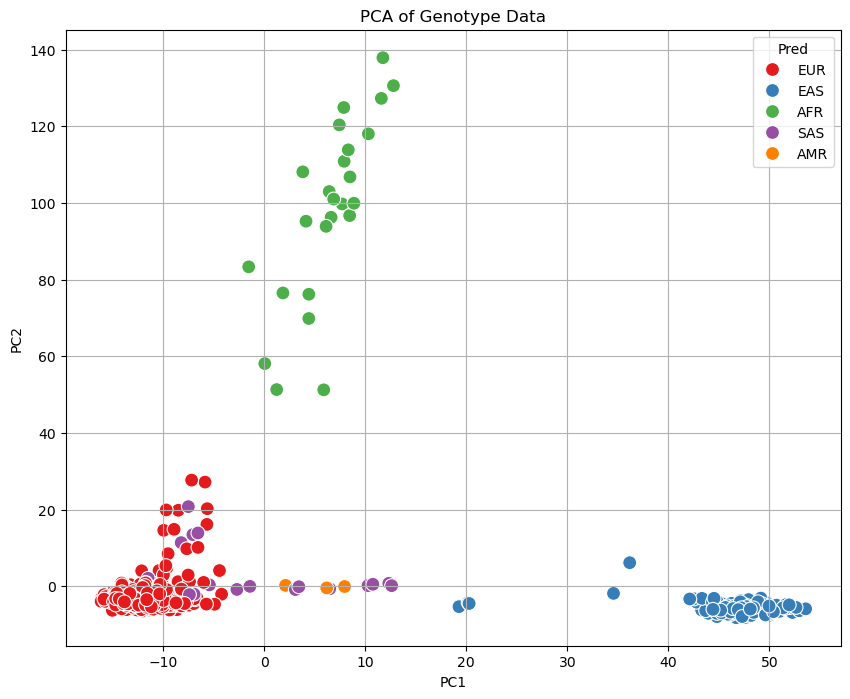

In [56]:
# List of specific sample IDs to highlight
highlight_ids = []


import seaborn as sns
import matplotlib.pyplot as plt

# Plot the PCA results with color labels
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Pred', data=merged_df, s=100, palette='Set1')

# Highlight specific IDs
for i, row in merged_df.iterrows():
    if row['Sample'] in highlight_ids:
        plt.text(row['PC1'] + 0.02, row['PC2'], row['Sample'], fontsize=9, color='black', weight='bold')
        plt.scatter(row['PC1'], row['PC2'], color='black', s=200, edgecolor='yellow', linewidth=2)  # Optional: Highlight with a larger marker

plt.title('PCA of Genotype Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()


In [85]:
svm_preds.to_excel('Ancestry_Predictions_SVM.xlsx', index = None)